In [ ]:
"""
Eng. Khaled hoshme
The following code, reviews the mechanism by which we can analyze and collect images of the chest x-rays of corona disease, 
the following method may help in determining the degree of infection with the corona virus, and whether the infection has its beginning or not.
Better results can be obtained the larger the image size the dataset contains.
Thus, the code clarifies the way in which it is possible to collect x-ray images of the chest area of ​​the Corona virus, 
with the aim of benefiting from it in determining the degree of infection with the virus.
"""

# Download Dataset

In [3]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

# Import Important Packages

In [40]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.cluster import KMeans
import cv2
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl

In [39]:
# The study focuses on x-ray images of the chest area infected with the Corona virus.
datasetFolder = "covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"

In [3]:
dataset = pathlib.Path(datasetFolder)

In [4]:
list_images = list(dataset.glob("*.*"))

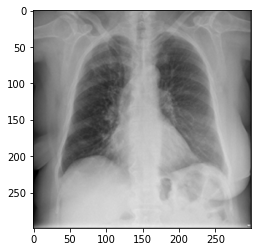

In [5]:
img = cv2.imread(os.path.join(list_images[0]))
plt.imshow(img)
plt.show()

# Extract Features

In [13]:
def ExtractFeatures(test_image):
  res = tf.keras.layers.Conv2D(32, (3, 3),activation = "relu", input_shape = (224, 224, 3), padding='same')(test_image)
  res = tf.keras.layers.MaxPool2D(2, 2)(res)
  res = tf.keras.layers.Dropout(0.2)(res)
  res = tf.keras.layers.Conv2D(16, (3, 3),activation = "relu", padding='same')(test_image)
  res = tf.keras.layers.MaxPool2D(2, 2)(res)
  res = tf.keras.layers.Dropout(0.2)(res)
  res = tf.keras.layers.Conv2D(8, (3, 3),activation = "relu", padding='same')(test_image)
  res = tf.keras.layers.MaxPool2D(2, 2)(res)
  res = tf.keras.layers.Dropout(0.2)(res)
  res = tf.keras.layers.Flatten()(res)
  return np.asarray(res[0])

In [7]:
def expand_dims_image(image):
  return np.expand_dims(image, axis = 0)

In [8]:
data = []
for img in list_images:
  img_ = cv2.imread(os.path.join(img))
  img_ = cv2.resize(img_, (224, 224))
  img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
  img_ = img_ / 255
  me = np.mean(img_)
  img_ = img_ - me
  img_ = img_ / np.std(img_)
  data.append(img_)

In [9]:
data = np.asarray(data)

In [10]:
data.shape

(3616, 224, 224, 3)

In [11]:
data[0]

array([[[-0.98053898, -0.98053898, -0.98053898],
        [-0.95908029, -0.95908029, -0.95908029],
        [-0.98053898, -0.98053898, -0.98053898],
        ...,
        [-1.13074976, -1.13074976, -1.13074976],
        [-1.21658449, -1.21658449, -1.21658449],
        [-1.77451024, -1.77451024, -1.77451024]],

       [[-1.25950185, -1.25950185, -1.25950185],
        [-1.23804317, -1.23804317, -1.23804317],
        [-1.1951258 , -1.1951258 , -1.1951258 ],
        ...,
        [-1.36679527, -1.36679527, -1.36679527],
        [-1.51700605, -1.51700605, -1.51700605],
        [-2.09639048, -2.09639048, -2.09639048]],

       [[-1.17366712, -1.17366712, -1.17366712],
        [-1.15220844, -1.15220844, -1.15220844],
        [-1.13074976, -1.13074976, -1.13074976],
        ...,
        [-1.34533658, -1.34533658, -1.34533658],
        [-1.43117131, -1.43117131, -1.43117131],
        [-2.05347312, -2.05347312, -2.05347312]],

       ...,

       [[-1.83888629, -1.83888629, -1.83888629],
        [-1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


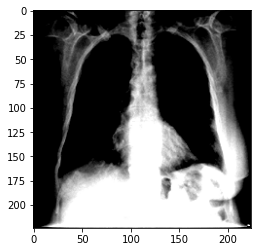

In [12]:
plt.imshow(data[0])
plt.show()

In [14]:
list_features = []
for img in data:
  img = expand_dims_image(img)
  features = ExtractFeatures(img)
  list_features.append(features)

In [15]:
list_features = np.asarray(list_features)

In [16]:
list_features.shape

(3616, 100352)

# Principal component analysis (PCA)
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result_pca = pca.fit_transform(list_features)

In [18]:
len(result_pca)

3616

# KMEANS Model

In [30]:
def modelClustering(n_clusters, data):
  return KMeans(n_clusters = n_clusters, random_state=0).fit(data)

In [35]:
def drawingResult(result_pca, labels, labels_centered):
  plt.rcParams["figure.figsize"] = (10,10)
  plt.scatter(result_pca[:,0], result_pca[:,1], c = labels, alpha=0.5, s=150)
  plt.scatter(labels_centered[:, 0], labels_centered[:, 1],
              marker='X', s=200, linewidths=1.5, color='red', edgecolors="black", lw=1.5)
  plt.title('COVID-19 Clustring')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')

#Clustering Chest X-ray COVID-19 Images Into 2 Clusters

In [32]:
kmeans = modelClustering(2, list_features)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

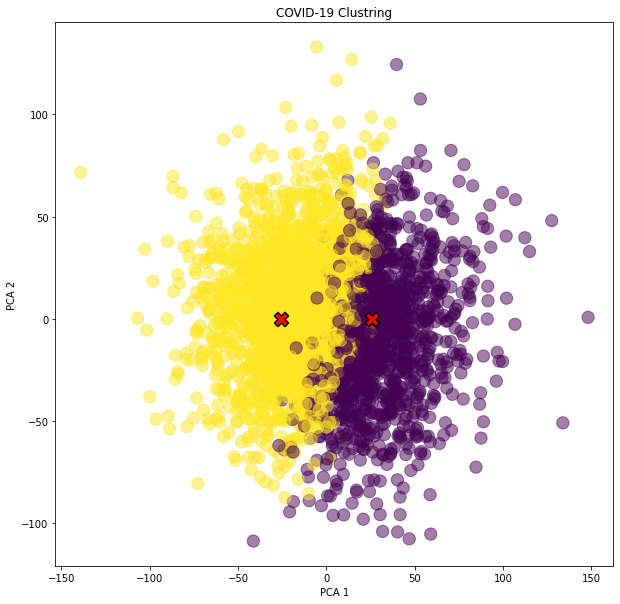

In [36]:
centroids = kmeans.cluster_centers_
labels_centered = pca.fit_transform(centroids)
drawingResult(result_pca, kmeans.labels_, labels_centered)

#Clustering Chest X-ray COVID-19 Images Into 3 Clusters

In [37]:
kmeans_3 = modelClustering(3, list_features)
kmeans_3.labels_

array([0, 1, 0, ..., 2, 2, 2], dtype=int32)

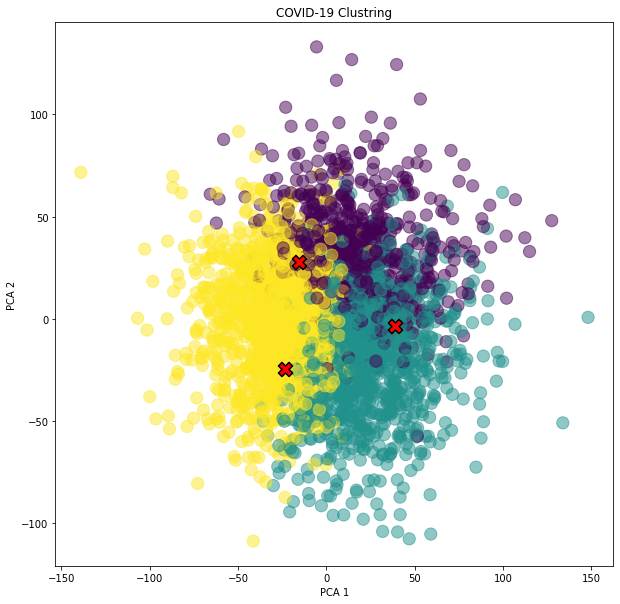

In [38]:
centroids = kmeans_3.cluster_centers_
labels_centered = pca.fit_transform(centroids)
drawingResult(result_pca, kmeans_3.labels_, labels_centered)